**Final Project: NYC Energy Consumption Prediction**

*Name: Peter Messina*

*CPSC 381/581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*


In this project, I use machine learning to accurately predict the energy consumption in New York City at any given hour in the day, given the date and the weather conditions.

**Submission**:

```
Key training and testing scores here (see summary at very end).
========== Linear Regression + Polynomial Expansion (degree 3) ==========
LinearRegression()
Testing set mean squared error: 9832.4795
Testing set r2 score: 0.9940

========== Ridge Regression with PCA + Polynomial Expansion (degree 4) ==========
Ridge(alpha=1)
Testing set mean squared error: 7779.4089
Testing set r2 score: 0.9952

========== Hist Gradient Boosting Regressor + Column Transfer ==========
Testing set mean squared error:: 4384.0953
Testing set r2 score: 0.9973
```

3. List any collaborators.

```
Collaborators: None

Collaboration details: N/A
```


**Notes**:
- The three best models were Linear Regression, Ridge Regression with PCA and Hist Gradient Boosting Regressor + Column Transform with one hot encoding and scaling. The final cell shows each of the three best models outputs for convenience.
- The below depicts the entire thought process and steps taken to reach the final three best models, this includes hyperparameter tuning and reasoning for trying the subsequent models.
- To run everything, select in the top bar Runtime --> Run all. Note, while making each cell I limited myself to 12GB of RAM while still necesitating that I achieve my measures of success. Selecting Run all requires more than 12 GB, so the file must be run with google colab pro with high RAM. Also, the path to the sql data must be changed to where the sql data was saved (this change must occur in cell 3).
- before each code cell, there is text of things I am looking out for and within the bottom of the code cell there is commented out text describing what I found.

In [2]:
import numpy as np
import sklearn.datasets as skdata
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpreprocess
from sklearn.linear_model import LinearRegression as LinearRegressionSciKit
from sklearn.linear_model import Ridge as RidgeRegressionSciKit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import warnings
import time

warnings.filterwarnings(action='ignore')
np.random.seed = 1

Helper function for plotting (From Exercise 7)

In [3]:
def plot_results(axis,
                 x_values,
                 y_values,
                 labels,
                 colors,
                 x_limits,
                 y_limits,
                 x_label,
                 y_label):
    '''
    Plots x and y values using line plot with labels and colors

    Args:
        axis :  pyplot.ax
            matplotlib subplot axis
        x_values : list[numpy[float32]]
            list of numpy array of x values
        y_values : list[numpy[float32]]
            list of numpy array of y values
        labels : str
            list of names for legend
        colors : str
            colors for each line
        x_limits : list[float32]
            min and max values of x axis
        y_limits : list[float32]
            min and max values of y axis
        x_label : list[float32]
            name of x axis
        y_label : list[float32]
            name of y axis
    '''

    # Iterate through x_values, y_values, labels, and colors and plot them
    # with associated legend
    for x, y, label, color in zip(x_values, y_values, labels, colors):
        axis.plot(x, y, marker='o', color=color, label=label)
        axis.legend(loc='best')

    # Set x and y limits
    axis.set_xlim(x_limits)
    axis.set_ylim(y_limits)

    # Set x and y labels
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

Importing the NYC dataset from the SQL database

In [4]:
# From exercise 11
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

import sqlite3
import pandas as pd

# TODO: If downloading this code, adjust the below to match where the database was saved.
drive.mount('/content/drive/', force_remount=True)
db_path = '/content/drive/MyDrive/Colab Notebooks/CPSC 381-581_ Machine Learning/Final Project/nyc_energy_and_weather.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# Load the full table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM nyc_hourly_merged_added", conn)

# view first few rows
df.head()


Mounted at /content/drive/


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,snowfall,pressure_msl,cloud_cover,wind_speed_10m,wind_direction_10m,...,day_of_week,is_weekend,year,month,day,is_holiday,Load,Load_lag1,Load_lag24,season
0,24.950300,66.367580,15.320299,18.901860,0.0,0.0,1030.0,2.0,0.707402,71.564964,...,1,0,2005,2,1,0,5078.050000,5551.327273,5036.009091,0
1,23.870300,67.280020,14.600300,17.579859,0.0,0.0,1029.8,0.0,1.140651,11.309895,...,1,0,2005,2,1,0,4810.963636,5078.050000,4825.409091,0
2,21.530300,70.528200,13.430302,14.849934,0.0,0.0,1029.9,0.0,1.844677,345.963700,...,1,0,2005,2,1,0,4675.925000,4810.963636,4687.654545,0
3,17.390300,76.203120,11.180302,10.062044,0.0,0.0,1029.5,0.0,2.984530,347.005370,...,1,0,2005,2,1,0,4615.027273,4675.925000,4639.854545,0
4,15.050299,79.736885,9.920300,7.192282,0.0,0.0,1029.9,14.0,4.032809,340.559880,...,1,0,2005,2,1,0,4632.609091,4615.027273,4673.736364,0


# Testing Different Machine Learning Models


Reasoning of which models I am testing:

The main models that we have learned are Perceptron, Logistic Regression, Linear Regression, Ridge Regression, Kernel Ridge Regression, and Principal Component Analysis. Below each of these main models are analyzed for their feasibility of use.
- Perceptron: best for classification, which is not what we are doing here
- Logistic Regression: also is best classification, not regression
- Linear Regression: good for what we want to do (regression)
- Ridge Regression: good for what we want to do
- Kernel Ridge Regression: good for nonlinear relationships, however the time and space it takes is dependent on N not d, and our N is > 100,000 so this is not the best choice.
- Principal Component Analysis: our dimensions are still relatively small, so may not be needed, but if I run out of RAM, then it could be helpful.

Load dataset (From exercise 7)

In [5]:
# Define target and feature columns
target_col = 'Load'
X = df.drop(columns=[target_col]).to_numpy()
y = df[target_col].to_numpy()

# print("X shape: " + str(X.shape)) # (175444, 21)
# print("y shape: " + str(y.shape)) # (175444,)

# Train/test split
print('Preprocessing the {} dataset ({} samples, {} feature dimensions)'.format("nyc weather and energy dataset", X.shape[0], X.shape[1]))

# Shuffle the dataset based on sample indices
shuffled_indices = np.random.permutation(X.shape[0])

# Choose the first 80% as training set and the rest as testing
train_split_idx = int(0.80 * X.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
test_indices = shuffled_indices[train_split_idx:]

# Select the examples from x and y to construct our training, validation, testing sets
X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]


Preprocessing the nyc weather and energy dataset dataset (175444 samples, 21 feature dimensions)


Training and testing linear regression (Code adapted from Exercise 7)

Starting with Linear Regression because it is simpler than ridge regression. The main hyperparameter to test here is the polynomial degree for polynomial expansion. The things to look out for are underfitting and overfitting.

Linear Regression with Polynomial Expansion

Training Linear Regression with degree 1 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-1 polynomial expansion
Training set mean squared error: 43726.8322
Training set r2 score: 0.9732
Testing set mean squared error: 43713.3002
Testing set r2 score: 0.9729

Training Linear Regression with degree 2 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-2 polynomial expansion
Training set mean squared error: 14864.6610
Training set r2 score: 0.9909
Testing set mean squared error: 14851.6492
Testing set r2 score: 0.9908

Training Linear Regression with degree 3 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-3 polynomial expansion
Training set mean squared error: 9840.4209
Training set r2 score: 0.9940
Testing set mean squared error: 9970.5897
Testing set r2 score: 0.9938


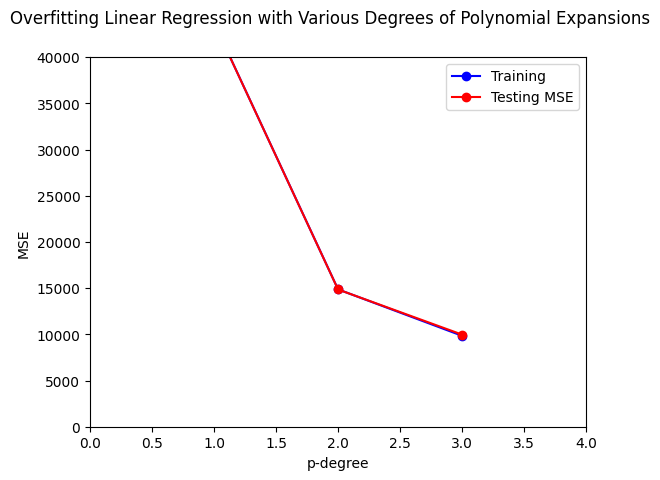

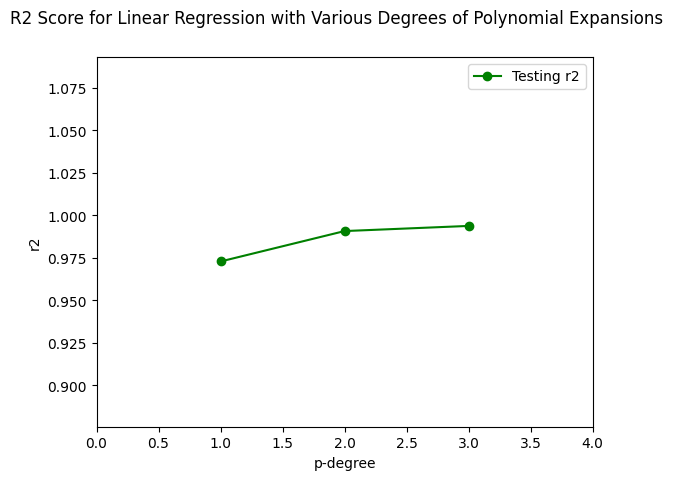

In [6]:
print('Linear Regression with Polynomial Expansion')


# Polynomial degrees to test
degrees = [1, 2, 3] # Runs out of ram at polynomial degree 4

# Lists for graphing MSE data
scores_mse_linear_overfit_train = []
scores_mse_linear_overfit_test = []
scores_r2_linear_test = []

# saving best model
best_mse = np.inf
model_lin_reg = None


for degree in degrees:
    print(f'\nTraining Linear Regression with degree {degree} polynomial expansion...')

    # Initialize polynomial expansion
    poly_transform = skpreprocess.PolynomialFeatures(degree=degree)

    # Compute the polynomial terms needed for the data
    poly_transform.fit(X_train)

    # Transform the data by nonlinear mapping
    X_poly_train = poly_transform.transform(X_train)
    X_poly_test = poly_transform.transform(X_test)

    # Initialize sci-kit linear regression model
    model_linear_overfit = LinearRegressionSciKit()

    # Train linear regression model
    model_linear_overfit.fit(X_poly_train, y_train)
    print(model_linear_overfit)

    print('Results for linear regression model with degree-{} polynomial expansion'.format(degree))

    # Test model on training set
    predictions_train = model_linear_overfit.predict(X_poly_train)
    score_mse_linear_overfit_train = skmetrics.mean_squared_error(y_train, predictions_train)
    print('Training set mean squared error: {:.4f}'.format(score_mse_linear_overfit_train))
    score_r2_linear_train = skmetrics.r2_score(y_train, predictions_train)
    print('Training set r2 score: {:.4f}'.format(score_r2_linear_train))

    # Save MSE training scores
    scores_mse_linear_overfit_train.append(score_mse_linear_overfit_train)

    # Test model on testing set
    predictions_test = model_linear_overfit.predict(X_poly_test)
    score_mse_linear_overfit_test = skmetrics.mean_squared_error(y_test, predictions_test)
    print('Testing set mean squared error: {:.4f}'.format(score_mse_linear_overfit_test))
    score_r2_linear_test = skmetrics.r2_score(y_test, predictions_test)
    print('Testing set r2 score: {:.4f}'.format(score_r2_linear_test))

    # Save MSE testing scores
    scores_mse_linear_overfit_test.append(score_mse_linear_overfit_test)
    scores_r2_linear_test.append(score_r2_linear_test)

    # save best model (using only MSE because this value has greater variation)
    # this step is explained in the last cell (mainly to summarize most important models)
    if score_mse_linear_overfit_test < best_mse:
      model_lin_reg = model_linear_overfit
      best_mse = score_mse_linear_overfit_test


# Convert each scores to NumPy arrays
scores_mse_linear_overfit_train = np.array(scores_mse_linear_overfit_train)
scores_mse_linear_overfit_test = np.array(scores_mse_linear_overfit_test)
scores_r2_linear_test = np.array(scores_r2_linear_test)

# Create figure for training and testing scores for different features
n_experiments = scores_mse_linear_overfit_train.shape[0]

labels = ['Training', 'Testing MSE']
colors = ['blue', 'red']

# Create a subplot of a 1 by 1 figure to plot MSE for training and testing
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Set x and y values
x_values = [range(1, n_experiments + 1)] * n_experiments
y_values = [
    scores_mse_linear_overfit_train,
    scores_mse_linear_overfit_test,
]


# Plot MSE scores for training and testing sets
plot_results(
    axis=ax,
    x_values=x_values,
    y_values=y_values,
    x_limits=[0, len(degrees)+1],
    y_limits=[0, 40000],
    labels=labels,
    colors=colors,
    x_label='p-degree',
    y_label='MSE')

# Create plot title of 'Overfitting Linear Regression with Various Degrees of Polynomial Expansions'
fig.suptitle('Overfitting Linear Regression with Various Degrees of Polynomial Expansions')

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
plot_results(
    axis=ax2,
    x_values=[range(1, n_experiments + 1)],
    y_values=[scores_r2_linear_test],
    x_limits=[0, len(degrees)+1],
    y_limits=[min(scores_r2_linear_test) * 0.9, max(scores_r2_linear_test) * 1.1],
    labels=['Testing r2'],
    colors=['green'],
    x_label='p-degree',
    y_label='r2')

fig2.suptitle('R2 Score for Linear Regression with Various Degrees of Polynomial Expansions')
plt.show() # to stop above line from returning text

# Notes:
# seems promising, but unfortunately RAM runs out before higher degrees can be tested
# no overfitting detected at degree 3, however testing ridge regression for any differences despite this and out of curiosity

Training and testing ridge regression (Code adapted from Assignment 3 and Exercise 7)

Here I am still exploring the models that are applicable that we learned in class. The goals are the same as above, and the hyperparameter being tested is the degree of the polynomial expansion.

Ridge(alpha=1)
Results for ridge regression model with weight decay of 1 for degree-3 polynomial expansion
Training set mean squared error: 8746.1907
Testing set mean squared error: 9070.4787
Ridge(alpha=2)
Results for ridge regression model with weight decay of 2 for degree-3 polynomial expansion
Training set mean squared error: 8752.5022
Testing set mean squared error: 9067.9606
Ridge(alpha=4)
Results for ridge regression model with weight decay of 4 for degree-3 polynomial expansion
Training set mean squared error: 8760.4330
Testing set mean squared error: 9063.5931
Ridge(alpha=8)
Results for ridge regression model with weight decay of 8 for degree-3 polynomial expansion
Training set mean squared error: 8770.6835
Testing set mean squared error: 9060.5896
Ridge(alpha=16)
Results for ridge regression model with weight decay of 16 for degree-3 polynomial expansion
Training set mean squared error: 8783.5868
Testing set mean squared error: 9061.4859
Ridge(alpha=32)
Results for ridge regr

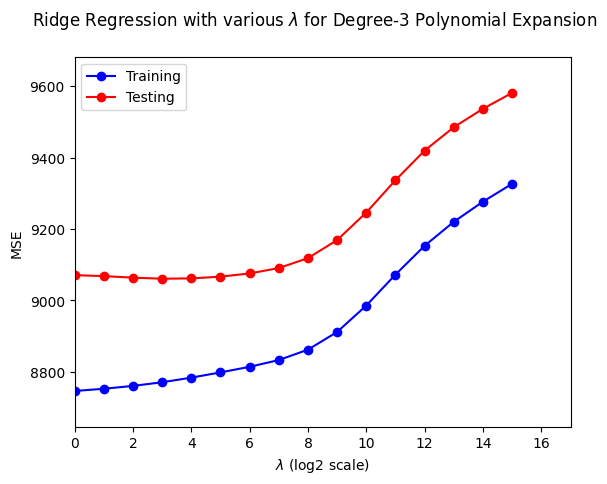

In [7]:

# Polynomial degrees to test
degrees = [3] # runs out of ram at degree 4

# weights 1 to 2^15 to test for weight decay
weight_decays = [2**i for i in range(16)]

# Lists for graphing data
scores_mse_linear_overfit_train = []
scores_mse_linear_overfit_test = []


for degree in degrees:

    # Initialize polynomial expansion
    poly_transform = skpreprocess.PolynomialFeatures(degree=degree)

    # Compute the polynomial terms needed for the data
    poly_transform.fit(X_train)

    # Transform the data by nonlinear mapping
    X_poly_train = poly_transform.transform(X_train)
    X_poly_test = poly_transform.transform(X_test)

    # Lists for graphing data
    scores_mse_ridge_poly_train = []
    scores_mse_ridge_poly_test = []

    for weight_decay in weight_decays:

      # Initialize ridge regression model
      model_ridge_poly = RidgeRegressionSciKit(alpha=weight_decay)

      # Train ridge regression model
      model_ridge_poly.fit(X_poly_train, y_train)
      print(model_ridge_poly)

      print('Results for ridge regression model with weight decay of {} for degree-{} polynomial expansion'.format(weight_decay, degree))

      # Test model on training set
      predictions_train = model_ridge_poly.predict(X_poly_train)
      score_mse_ridge_poly_train = skmetrics.mean_squared_error(y_train, predictions_train)
      print('Training set mean squared error: {:.4f}'.format(score_mse_ridge_poly_train))

      # Save MSE training scores
      scores_mse_ridge_poly_train.append(score_mse_ridge_poly_train)

      # Test model on testing set
      predictions_test = model_ridge_poly.predict(X_poly_test)
      score_mse_ridge_poly_test = skmetrics.mean_squared_error(y_test, predictions_test)
      print('Testing set mean squared error: {:.4f}'.format(score_mse_ridge_poly_test))

      # Save MSE testing scores
      scores_mse_ridge_poly_test.append(score_mse_ridge_poly_test)


    # Convert each scores to NumPy arrays
    scores_mse_ridge_poly_train = np.array(scores_mse_ridge_poly_train)
    scores_mse_ridge_poly_test = np.array(scores_mse_ridge_poly_test)

    # Create figure for training and testing scores for different features
    n_experiments = scores_mse_ridge_poly_train.shape[0]

    labels = ['Training', 'Testing']
    colors = ['blue', 'red']

    # Create the first subplot of a 1 by 1 figure to plot MSE for training and testing
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Set x values (weight_decays in log base2 scale) and y values (MSE)
    x_values = [[np.log2(weight_decay) for weight_decay in weight_decays]] * n_experiments
    y_values = [
        scores_mse_ridge_poly_train,
        scores_mse_ridge_poly_test
    ]

    # Plot MSE scores for training and testing sets
    plot_results(
        axis=ax,
        x_values=x_values,
        y_values=y_values,
        labels=labels,
        colors=colors,
        x_limits=[0, len(weight_decays)+1],
        y_limits=[min(min(scores_mse_ridge_poly_train), min(scores_mse_ridge_poly_test)) - 100,
          max(max(scores_mse_ridge_poly_train), max(scores_mse_ridge_poly_test)) + 100],
        x_label=r'$\lambda$ (log2 scale)',
        y_label='MSE'
        )


    # Create plot title of r'Ridge Regression with various $\lambda$ for Degree-{} Polynomial Expansion'.format(degree)
    fig.suptitle(r'Ridge Regression with various $\lambda$ for Degree-{} Polynomial Expansion'.format(degree))


# Notes:
# not needed because the linear regression is not overfitting as the RAM runs out before overfitting occurs
# as expected no real need for this now, but this will be interesting if PCA will let us get higher degrees with less dimensions.
# not going to save this output of best model because linear regression is similar and yielded basically the same results

Principal Component Analysis (Code from exercise 10)

Both Linear Regression and Ridge Regression were limited by the RAM on the system. At higher polynomial degrees, the RAM would run out, so the goal of the PCA is to limit the dimensionality to hopefully achieve higher degree polynomial expansion and then hopefully get better fit with either or both of the models.

Below, the goal is to see the amount of loss from removing a given number of dimensions to see what number of components is necessary to still capture most of the variance of the data/not loose too much information.

***** Fitting PCA with 1 components *****
Training set mean squared error: 9286.0157
Validation set mean squared error: 9201.4632
***** Fitting PCA with 2 components *****
Training set mean squared error: 648.2907
Validation set mean squared error: 649.1892
***** Fitting PCA with 3 components *****
Training set mean squared error: 145.6400
Validation set mean squared error: 146.2609
***** Fitting PCA with 4 components *****
Training set mean squared error: 70.3478
Validation set mean squared error: 70.6421
***** Fitting PCA with 5 components *****
Training set mean squared error: 27.2771
Validation set mean squared error: 27.5472
***** Fitting PCA with 6 components *****
Training set mean squared error: 13.0078
Validation set mean squared error: 13.1205
***** Fitting PCA with 7 components *****
Training set mean squared error: 9.2017
Validation set mean squared error: 9.2383
***** Fitting PCA with 8 components *****
Training set mean squared error: 5.5122
Validation set mean squared er

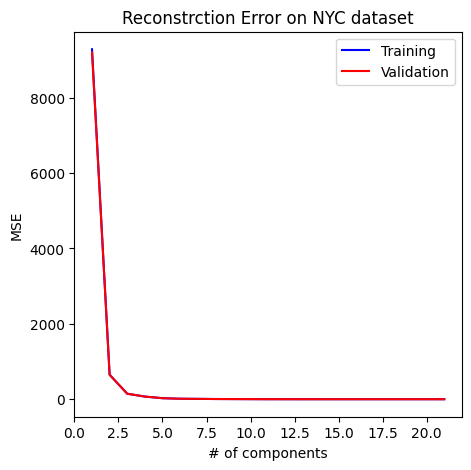

In [8]:
# Number of dimensions of subspace
components_range = range(1, 22)

# Define empty lists to hold scores for training and validation
mse_scores_train = []
mse_scores_test = []

for components in components_range:

    print('***** Fitting PCA with {} components *****'.format(components))

    # Instantiate PCA with specified components (dimensions)
    pca = PCA(n_components=components)

    # Fit PCA to training data
    pca.fit(X_train)

    # Project the training data, reconstruct them, and measure loss
    Z_train = pca.transform(X_train)
    X_hat_train = pca.inverse_transform(Z_train)

    mse_score_train = skmetrics.mean_squared_error(X_train, X_hat_train)
    print('Training set mean squared error: {:.4f}'.format(mse_score_train))

    # Project the validation data, reconstruct them, and measure loss
    Z_test = pca.transform(X_test)
    X_hat_test = pca.inverse_transform(Z_test)

    mse_score_test = skmetrics.mean_squared_error(X_test, X_hat_test)
    print('Validation set mean squared error: {:.4f}'.format(mse_score_test))

    # Append training and validation scores to lists of training and validation scores
    mse_scores_train.append(mse_score_train)
    mse_scores_test.append(mse_score_test)

# Create figure with figsize=(5, 5)
fig = plt.figure(figsize=(5,5))

# Instantiate axis for subplot of a 1 x 1 figure
ax = fig.add_subplot(1,1,1)

# Plot the the number of components on the x-axis and training mse scores on the y-axis with color='blue', label='Training'
ax.plot(components_range, mse_scores_train, color='blue', label='Training')

# Plot the the number of components on the x-axis and validation mse scores on the y-axis with color='red', label='Validation'
ax.plot(components_range, mse_scores_test, color='red', label='Validation')

# Set title to 'Reconstrction Error on {} dataset'
ax.set_title(f'Reconstrction Error on NYC dataset')

# Set xlabel to '# of components'
ax.set_xlabel('# of components')

# Set ylabel to 'MSE'
ax.set_ylabel('MSE')

# Set legend with loc='upper right'
ax.legend(loc='upper right')

plt.show()
print('')
print('')

# Notes: going by the statistical significance rules, I want MSE ~ 0.10, which means I will use components=15 as that captures ~90% of the variance

Linear Regression with PCA

The goal is to see at what is the maximum number of components we can use with PCA to get the dimensions small enough that the polynomial expansion can occur at a higher degree, and then see if that higher degree experiences overfitting or has a better fit than Linear Regression without PCA. The hyperparameters we are adjusting is the degree of polynomial expansion and then manually the number of components of PCA.

Linear Regression with PCA + Polynomial Expansion

Training Linear Regression with degree 1 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-1 polynomial expansion
Training set mean squared error: 44253.0464
Testing set mean squared error: 44194.7987

Training Linear Regression with degree 2 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-2 polynomial expansion
Training set mean squared error: 17295.3952
Testing set mean squared error: 17230.0031

Training Linear Regression with degree 3 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-3 polynomial expansion
Training set mean squared error: 11404.9216
Testing set mean squared error: 11388.4921

Training Linear Regression with degree 4 polynomial expansion...
LinearRegression()
Results for linear regression model with degree-4 polynomial expansion
Training set mean squared error: 26367.0805
Testing set mean squa

Text(0.5, 0.98, 'Overfitting Linear Regression with Various Degrees of Polynomial Expansions')

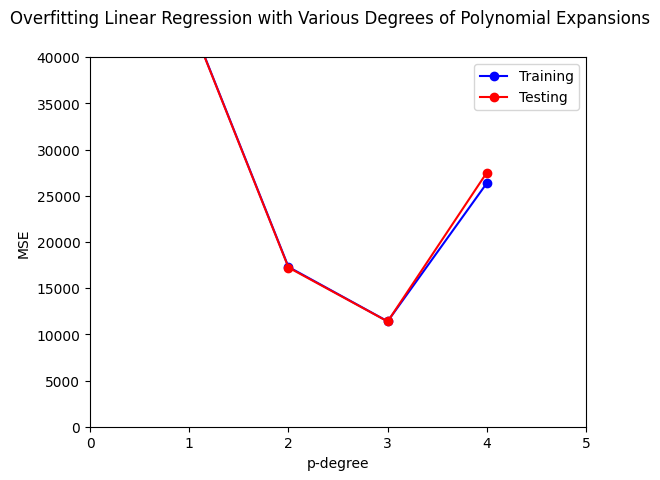

In [9]:
# Apply PCA once outside the loop to reduce dimensions to 15
pca = PCA(n_components=15) # 15
pca.fit(X_train)

# Transform both train and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Linear Regression with PCA + Polynomial Expansion')

# Polynomial degrees to test
degrees = [1, 2, 3, 4] # Runs out of ram at polynomial degree 5

# Lists for graphing MSE data
scores_mse_linear_overfit_train = []
scores_mse_linear_overfit_test = []


for degree in degrees:
    print(f'\nTraining Linear Regression with degree {degree} polynomial expansion...')

    # Initialize polynomial expansion
    poly_transform = skpreprocess.PolynomialFeatures(degree=degree)

    # Compute the polynomial terms needed for the data
    poly_transform.fit(X_train_pca)

    # Transform the data by nonlinear mapping
    X_poly_train = poly_transform.transform(X_train_pca)
    X_poly_test = poly_transform.transform(X_test_pca)

    # Initialize sci-kit linear regression model
    model_linear_overfit = LinearRegressionSciKit()

    # Train linear regression model
    model_linear_overfit.fit(X_poly_train, y_train)
    print(model_linear_overfit)

    print('Results for linear regression model with degree-{} polynomial expansion'.format(degree))

    # Test model on training set
    predictions_train = model_linear_overfit.predict(X_poly_train)
    score_mse_linear_overfit_train = skmetrics.mean_squared_error(y_train, predictions_train)
    print('Training set mean squared error: {:.4f}'.format(score_mse_linear_overfit_train))

    # Save MSE training scores
    scores_mse_linear_overfit_train.append(score_mse_linear_overfit_train)

    # Test model on testing set
    predictions_test = model_linear_overfit.predict(X_poly_test)
    score_mse_linear_overfit_test = skmetrics.mean_squared_error(y_test, predictions_test)
    print('Testing set mean squared error: {:.4f}'.format(score_mse_linear_overfit_test))

    # Save MSE testing scores
    scores_mse_linear_overfit_test.append(score_mse_linear_overfit_test)


# Convert each scores to NumPy arrays
scores_mse_linear_overfit_train = np.array(scores_mse_linear_overfit_train)
scores_mse_linear_overfit_test = np.array(scores_mse_linear_overfit_test)

# Create figure for training and testing scores for different features
n_experiments = scores_mse_linear_overfit_train.shape[0]

labels = ['Training', 'Testing']
colors = ['blue', 'red']

# Create a subplot of a 1 by 1 figure to plot MSE for training and testing
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Set x and y values
x_values = [range(1, n_experiments + 1)] * n_experiments
y_values = [
    scores_mse_linear_overfit_train,
    scores_mse_linear_overfit_test
]


# Plot MSE scores for training and testing sets
plot_results(
    axis=ax,
    x_values=x_values,
    y_values=y_values,
    x_limits=[0, len(degrees)+1],
    y_limits=[0, 40000],
    labels=labels,
    colors=colors,
    x_label='p-degree',
    y_label='MSE')

# Create plot title of 'Overfitting Linear Regression with Various Degrees of Polynomial Expansions'
fig.suptitle('Overfitting Linear Regression with Various Degrees of Polynomial Expansions')

# Notes:
# with 20 components run out of RAM at degree 4 with 9,000 MSE testing
# with 18 components run out of RAM at degree 4 with 10,000 MSE testing
# with 17 components run out of RAM at degree 4 with 11,000 MSE testing
# with 16 components run out of RAM at degree 4 with 11,500 MSE testing
# with 15 components run out of RAM at degree 5 with 11,000 MSE testing and has potential overfitting (but this is still worse than non PCA)
# with 10 components run out of RAM at degree 5 with 40,000 MSE (wanted to see if another degree was worth it, but anyless than 10 components results in too much loss of information and the degree is still max 4)


Ridge Regression with PCA

At 15 components, the linear regression was able to run with polynomial expansion of degree 4, and the results show some signs of overfitting, so now the goal is to see the max number of components PCA can have to have the polynomial expansion be of degree 4, then see if a better fit can be achieved vs linear regression. The hyperparameters tuned here are PCA number of components (manual tuning) and weight decays for regularization.

Ridge Regression with PCA + Polynomial Expansion
Ridge(alpha=1)
Results for ridge regression model with weight decay of 1 for degree-4 polynomial expansion
Training set mean squared error: 7418.9047
Training set r2 score: 0.9955
Testing set mean squared error: 7902.4236
Testing set r2 score: 0.9951
Ridge(alpha=2)
Results for ridge regression model with weight decay of 2 for degree-4 polynomial expansion
Training set mean squared error: 7418.9051
Training set r2 score: 0.9955
Testing set mean squared error: 7902.4558
Testing set r2 score: 0.9951
Ridge(alpha=4)
Results for ridge regression model with weight decay of 4 for degree-4 polynomial expansion
Training set mean squared error: 7418.9063
Training set r2 score: 0.9955
Testing set mean squared error: 7902.5186
Testing set r2 score: 0.9951
Ridge(alpha=8)
Results for ridge regression model with weight decay of 8 for degree-4 polynomial expansion
Training set mean squared error: 7418.9108
Training set r2 score: 0.9955
Testing set mean s

Text(0.5, 0.98, 'Ridge Regression with various $\\lambda$ for Degree-4 Polynomial Expansion')

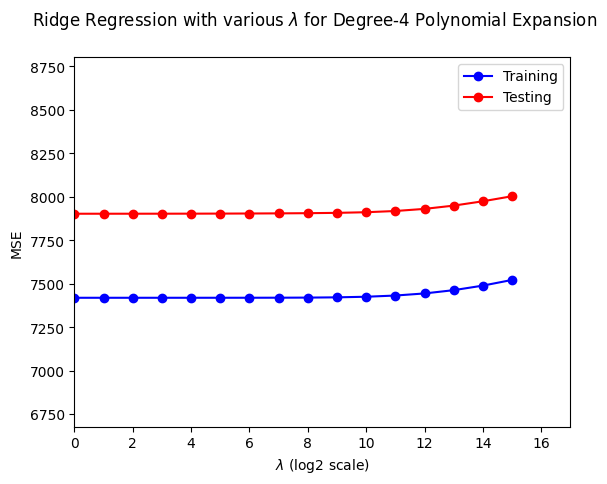

In [10]:
# testing PCA with ridge regression b/c degree 4 above was promising but had minor overfitting, also curious

# Apply PCA once outside the loop to reduce dimensions to 15
pca = PCA(n_components=15) # 15
pca.fit(X_train)

# Transform both train and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Ridge Regression with PCA + Polynomial Expansion')
# Polynomial degrees to test
degree = 4 # runs out of ram at degree 5 (known from above)

# weights 1 to 2^15 to test for weight decay
weight_decays = [2**i for i in range(16)]

# Lists for graphing data
scores_mse_linear_overfit_train = []
scores_mse_linear_overfit_test = []
best_mse = np.inf
model_pca_ridge = None

# Initialize polynomial expansion
poly_transform = skpreprocess.PolynomialFeatures(degree=degree)

# Compute the polynomial terms needed for the data
poly_transform.fit(X_train_pca)

# Transform the data by nonlinear mapping
X_poly_train = poly_transform.transform(X_train_pca)
X_poly_test = poly_transform.transform(X_test_pca)

# Lists for graphing data
scores_mse_ridge_poly_train = []
scores_mse_ridge_poly_test = []

for weight_decay in weight_decays:

  # Initialize ridge regression model
  model_ridge_poly = RidgeRegressionSciKit(alpha=weight_decay)

  # Train ridge regression model
  model_ridge_poly.fit(X_poly_train, y_train)
  print(model_ridge_poly)

  print('Results for ridge regression model with weight decay of {} for degree-{} polynomial expansion'.format(weight_decay, degree))

  # Test model on training set
  predictions_train = model_ridge_poly.predict(X_poly_train)
  score_mse_ridge_poly_train = skmetrics.mean_squared_error(y_train, predictions_train)
  print('Training set mean squared error: {:.4f}'.format(score_mse_ridge_poly_train))
  score_r2_linear_train = skmetrics.r2_score(y_train, predictions_train)
  print('Training set r2 score: {:.4f}'.format(score_r2_linear_train))

  # Save MSE training scores
  scores_mse_ridge_poly_train.append(score_mse_ridge_poly_train)

  # Test model on testing set
  predictions_test = model_ridge_poly.predict(X_poly_test)
  score_mse_ridge_poly_test = skmetrics.mean_squared_error(y_test, predictions_test)
  print('Testing set mean squared error: {:.4f}'.format(score_mse_ridge_poly_test))
  score_r2_ridge_poly_test = skmetrics.r2_score(y_test, predictions_test)
  print('Testing set r2 score: {:.4f}'.format(score_r2_ridge_poly_test))

  # Save MSE testing scores and best model
  # this step is explained at the last cell (basically for summarizing key models)
  scores_mse_ridge_poly_test.append(score_mse_ridge_poly_test)
  if score_mse_ridge_poly_test < best_mse:
    model_pca_ridge = model_ridge_poly
    best_mse = score_mse_ridge_poly_test


# Convert each scores to NumPy arrays
scores_mse_ridge_poly_train = np.array(scores_mse_ridge_poly_train)
scores_mse_ridge_poly_test = np.array(scores_mse_ridge_poly_test)

# Create figure for training and testing scores for different features
n_experiments = scores_mse_ridge_poly_train.shape[0]

labels = ['Training', 'Testing']
colors = ['blue', 'red']

# Create the first subplot of a 1 by 1 figure to plot MSE for training and testing
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Set x values (weight_decays in log base2 scale) and y values (MSE)
x_values = [[np.log2(weight_decay) for weight_decay in weight_decays]] * n_experiments
y_values = [
    scores_mse_ridge_poly_train,
    scores_mse_ridge_poly_test
]

# Plot MSE scores for training and testing sets
plot_results(
    axis=ax,
    x_values=x_values,
    y_values=y_values,
    labels=labels,
    colors=colors,
    x_limits=[0, len(weight_decays)+1],
    y_limits=[min(np.min(y) for y in y_values) * 0.9, max(np.max(y) for y in y_values) * 1.1],
    x_label=r'$\lambda$ (log2 scale)',
    y_label='MSE'
    )


# Create plot title of r'Ridge Regression with various $\lambda$ for Degree-{} Polynomial Expansion'.format(degree)
fig.suptitle(r'Ridge Regression with various $\lambda$ for Degree-{} Polynomial Expansion'.format(degree))


# Notes:
# double checked and with polynomial expansion with degree 4, 15 components is the highest without crashing (16 crashed)
# some of the best results

# Model Recommended by the Internet

# Hist Gradient Boosting Regressor + Column Transformer

From class, I knew that my data had an issue with scaling and with being categorical after searching for scaling solutions and finding that it would force a mean and standard deviation (not great for discrete values) From that I found I could separate my categorical data and discrete data, and that discrete data can be better understood through one hot encoding. This led to me using the Column Transformer within scikit.

Column Transformer: The purpose of Column Transformer is to help me with both the scaling of my data, some of the values are in the thousands while others are between 0 and 1, and also because some of my data points are discrete values (day, month, hour, etc.) that repeat and others are numerical.
Column transformer solves the scaling issue by using Scikits Standard Scalar which takes the numeric data and scaling them to have mean of 0 and standard deviation of 1, keeping the information about the spread and thus impact of the feature without needing it to be too large or too small that training gets skewed.
Column transformer also changes the discrete values into one-hot encodings with Scikits OneHotEncoder. This is because to a regular model, 1 and 2 are quite close together and so it thinks these values are not that different, and in relation 1 and 7 are very far, however these are just days of the week. One Hot encoding allows for the model to see that all discrete values are equally unrelated. (Also, sparse_output=False because HistGradientBoostingRegressor would not work with it as True)


Then in general when searching for models for energy prediction that would fit my dataset (with categorical and numeric data), gradient boosted trees came up. This is because they handle structed data and feature ranking well as well as the issues that come up from the lack of scaling and the discrete categorical data (but I left in the preprocessing because it was cool and couldn't hurt). From that I looked up scikit's version and it was HistGradientBoostingRegression.

Finally, in order to preprocess the features separately and then bring them together and then use the gradient boosted trees, scikit has a pipeline to combine all of these steps. More so to make this whole idea into one model than anything.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor

# feature engineering to deal with scaling and categorical data problem
target = "Load"
X = df.drop(columns=["Load"])
y = df[target].to_numpy()

# Shuffle the dataset based on sample indices
shuffled_indices = np.random.permutation(X.shape[0])

# Choose the first 80% as training set, the rest as testing
train_split_idx = int(0.80 * X.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
test_indices = shuffled_indices[train_split_idx:]

# Select the examples from X and y to construct our training, validation, testing sets
X_train, y_train = X.iloc[train_indices, :], y[train_indices]
X_test, y_test = X.iloc[test_indices, :], y[test_indices]


num_features = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "apparent_temperature", "precipitation", "snowfall", "pressure_msl",
    "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m",
    "Load_lag1"
]
cat_features = ['hour', 'day_of_week', 'is_weekend', 'is_holiday', 'day', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('regressor', HistGradientBoostingRegressor())
])

model.fit(X_train, y_train)
model_hgbr_colTrans = model # saving model for final display
print(model)


# Evaluate
predictions_test = model.predict(X_test)
mse_hgbr = skmetrics.mean_squared_error(y_test, predictions_test)
r2_score_hgbr = skmetrics.r2_score(y_test, predictions_test)
print("Testing set mean squared error:: {:.4f}".format(mse_hgbr))
print("Testing set r2 score: {:.4f}".format(r2_score_hgbr))


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature_2m',
                                                   'relative_humidity_2m',
                                                   'dew_point_2m',
                                                   'apparent_temperature',
                                                   'precipitation', 'snowfall',
                                                   'pressure_msl',
                                                   'cloud_cover',
                                                   'wind_speed_10m',
                                                   'wind_direction_10m',
                                                   'wind_gusts_10m',
                                                   'Load_lag1']),
                                                 ('cat',
                                                  OneHotEncoder(

Most Important and Best Models From Above

In [12]:
# display the mse and r2 of all of the best/most important models, for viewing sake (need to run all previous cells to run, not just top 4)

# feature engineering to deal with scaling and categorical data problem
target = "Load"
X = df.drop(columns=["Load"])
y = df[target].to_numpy()

# Shuffle the dataset based on sample indices
shuffled_indices = np.random.permutation(X.shape[0])

# Choose the first 80% as training set, the rest as testing
train_split_idx = int(0.80 * X.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
test_indices = shuffled_indices[train_split_idx:]

# Select the examples from X and y to construct our training, validation, testing sets
X_train, y_train = X.iloc[train_indices, :], y[train_indices]
X_test, y_test = X.iloc[test_indices, :], y[test_indices]


# ========== best linear regression model (based on polynomial degrees tested) ==========
print('========== Linear Regression + Polynomial Expansion (degree 3) ==========')
# Initialize polynomial expansion
poly_transform = skpreprocess.PolynomialFeatures(degree=3)
# Compute the polynomial terms needed for the data
poly_transform.fit(X_train)
# Transform the data by nonlinear mapping
X_poly_train = poly_transform.transform(X_train)
X_poly_test = poly_transform.transform(X_test)
print(model_lin_reg)
predictions_test = model_lin_reg.predict(X_poly_test)
score_mse_linear_overfit_test = skmetrics.mean_squared_error(y_test, predictions_test)
print('Testing set mean squared error: {:.4f}'.format(score_mse_linear_overfit_test))
score_r2_linear_test = skmetrics.r2_score(y_test, predictions_test)
print('Testing set r2 score: {:.4f}'.format(score_r2_linear_test))
print('')


# ========== Best Ridge Regression with PCA and Polynomial Expansion model (based on weight_decays tested) ==========
print('========== Ridge Regression with PCA + Polynomial Expansion (degree 4) ==========')
print(model_pca_ridge)
# must run PCA to use X_poly_test
# Apply PCA once outside the loop to reduce dimensions to 15
pca = PCA(n_components=15) # from above testing
pca.fit(X_train)
# Transform both train and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
# Polynomial degrees to test
degree = 4 # runs out of ram at degree 5 (known from above)
# Initialize polynomial expansion
poly_transform = skpreprocess.PolynomialFeatures(degree=degree)
# Compute the polynomial terms needed for the data
poly_transform.fit(X_train_pca)
# Transform the data by nonlinear mapping
X_poly_train = poly_transform.transform(X_train_pca)
X_poly_test = poly_transform.transform(X_test_pca)
model_pca_ridge.fit(X_poly_train, y_train)
predictions_test = model_pca_ridge.predict(X_poly_test)
score_mse_ridge_poly_test = skmetrics.mean_squared_error(y_test, predictions_test)
print('Testing set mean squared error: {:.4f}'.format(score_mse_ridge_poly_test))
score_r2_ridge_poly_test = skmetrics.r2_score(y_test, predictions_test)
print('Testing set r2 score: {:.4f}'.format(score_r2_ridge_poly_test))
print('')


# ========== Hist Gradient Boosting Regressor + Column Transfer ==========
# the model already contains all the needed information, so can immediately predict
print('========== Hist Gradient Boosting Regressor + Column Transfer ==========')
print(model_hgbr_colTrans)
predictions_test = model_hgbr_colTrans.predict(X_test)
mse_hgbr = skmetrics.mean_squared_error(y_test, predictions_test)
r2_score_hgbr = skmetrics.r2_score(y_test, predictions_test)
print("Testing set mean squared error:: {:.4f}".format(mse_hgbr))
print("Testing set r2 score: {:.4f}".format(r2_score_hgbr))



========== Linear Regression + Polynomial Expansion (degree 3) ==========
LinearRegression()
Testing set mean squared error: 9832.4795
Testing set r2 score: 0.9940

========== Ridge Regression with PCA + Polynomial Expansion (degree 4) ==========
Ridge(alpha=1)
Testing set mean squared error: 7779.4089
Testing set r2 score: 0.9952

========== Hist Gradient Boosting Regressor + Column Transfer ==========
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature_2m',
                                                   'relative_humidity_2m',
                                                   'dew_point_2m',
                                                   'apparent_temperature',
                                                   'precipitation', 'snowfall',
                                                   'pressure_msl',
                                                   'cloud

The first model was the first model I tested. Here we got issues with RAM that resulted in me not being able to overfit from too high a degree of polynomial expansion. This meant that the subsequent ridge regression resulted in basically the same values. While the MSE and r2 score were quite good, I wanted to see if I could still experience the overfitting from a higher degree and so I went to PCA to get rid of some features to get a higher degree without going over the RAM limit.

Then that lead me to using PCA to get to degree 4 polynomial expansion, one degree higher than without PCA. This had the effect of allowing the regularizer within the ridge regressor model to have a more significant impact. The MSE decreased from around 10,000 to around 8,000 for the testing dataset. I was happy with the ~8,000 MSE and 0.9951 r2 score, which satisfied my goals, but I wanted to see what the internet thought.

This finally lead to the Hist Gradient Boosting Regressor and Column Transform with scaling and one-hot encoding. The main thing my previous models did not address was that some of my data was not scaled and had very high values (like load lag) and that some of my data was categorical (like is_weekend either being only 1 or 0). The combination was bad because first, the lack of scaling means that the larger features would have more weight compared to the small ones when they should all be equally effective, and my categorical data meant that the model would think that 1 = Monday was closer in similarity to 2 = Tuesday and much farther from 7 = Sunday when in reality they are all equidistant in relation. The scaling was solved by the Scikit scalar, the categorical data was solved by the one-hot-encoding and the fact that my features were either numeric or categorical was solved with Column transform that split them, and the Gradient Bosted Tree is generally good with both numeric and categorical types, so it helps with the issue. Finally these were all able to be combined into one model through the pipline. By dealing with this issue, the best result was found to be ~4,500 MSE and r2 score of 0.9973

**Measure of Success:**
my measure of success was to be able to predict the energy consumption at various hours of the day any day in the year given that date and the weather. My goal was to be able to predict that with a margin of error of 10% - 20%.

The best model (Hist Gradient Boosting Regressor and Column Transform with scaling and one-hot encoding) achieved MSE values of 4500 and an r2 score of 0.9973. The MSE value of 4500 means that on average the model is off by sqrt(4500) ~ 67. The minimum energy load experienced in a given hour in NYC was 2861MW which means that the model is on average off by 2.341% in the worst case (see the code below for how i calculate this) which is well within my measure of success, and even though this is just on average, given that my model was said not to have to be accurate on extreme days like the weather being 120 degrees, I feel comfortable saying the model was successful and has the ability to predict the energy consumption at various hours of the day any day in NYC given the weather with a margin of error of 10%. Also, the R2 score signifies that 99.73% of the variation in energy load is explained by the model, such strong correlation is a good sign of success of the model.

It is also worth noting that the linear regression model with a MSE of around 10,000 meant that on average the model was off by 100, which is on average off by 3.495% and that the ridge regression model with PCA with an MSE of around 8,000 was on average off by 89.443 with means off by on average off by 3.126% in the worst case. So the class models were in fact good enough for the machine learning problem, but the online version takes into account problems with the features that we did not address in class that make it even better. Overall this project was a successful.

In [13]:
print("minimum energy load: {:.4f}".format(min(y)))
print("maximum energy load: {:.4f}".format(max(y)))
print("Sqrt(MSE) percentage of the minimum load: {:.4f}%".format((67/min(y) * 100)))

minimum energy load: 2861.6167
maximum energy load: 11452.2167
Sqrt(MSE) percentage of the minimum load: 2.3413%


Note:
- I ran the RAM tests individually, so when I tried to run everything together, there was not enough RAM, so with Colab Pro+ I increased the RAM to be able to run everything together, so in order to run my machine learning project, there must be > 12 GB of RAM